In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from collections import defaultdict, Counter
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

In [2]:
np.random.seed(0)

### User information

In [3]:
user_cols = ['userid', 'age', 'gender', 'occupation', 'zip code']
user_df = pd.read_csv('ml-100k/u.user', sep='|', names=user_cols, encoding='latin-1', index_col='userid')
num_users = user_df.shape[0]
user_df.head()

,age,gender,occupation,zip code
userid,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [4]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 1 to 943
Data columns (total 4 columns):
age           943 non-null int64
gender        943 non-null object
occupation    943 non-null object
zip code      943 non-null object
dtypes: int64(1), object(3)
memory usage: 36.8+ KB


### Movie information

In [5]:
movie_cols = ['movieid', 'movie_title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 
             'Animation', 'Childrens', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
             'Musical', 'Mystery', 'Romance ', 'Sci-Fi', 'Thriller', 'War', 'Western']
movie_df = pd.read_csv('ml-100k/u.item', sep='|', names=movie_cols, encoding='latin-1', index_col='movieid')
num_movies = movie_df.shape[0]
movie_df.head()

,movie_title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Childrens,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 1682
Data columns (total 23 columns):
movie_title           1682 non-null object
release_date          1681 non-null object
video_release_date    0 non-null float64
IMDb_URL              1679 non-null object
unknown               1682 non-null int64
Action                1682 non-null int64
Adventure             1682 non-null int64
Animation             1682 non-null int64
Childrens             1682 non-null int64
Comedy                1682 non-null int64
Crime                 1682 non-null int64
Documentary           1682 non-null int64
Drama                 1682 non-null int64
Fantasy               1682 non-null int64
Film-Noir             1682 non-null int64
Horror                1682 non-null int64
Musical               1682 non-null int64
Mystery               1682 non-null int64
Romance               1682 non-null int64
Sci-Fi                1682 non-null int64
Thriller              1682 non-null int64
War      

## Recommender System:  User-based Collaborative Filter
* * *
In this case, we are going to be build a simple recommender system, which is a user-based collaborative filter. Key Idea of this system is based on the materials presented in Chapter 4 of Recommender System Handbook (A very good book to have in collection).  I have provided a link for this book in our [github repo](https://github.com/bipsmlbd/reading_materials/blob/master/BOOKS.md#recsys). The above created dataframes are not useful for such a system, since it is oblivious to content of the items or profile of the users. Such information are useful for more robust recommender system. 
* * *

### Ratings Info

In [7]:
rating_cols = ['userid', 'movieid', 'rating', 'timestamp']
ratings_df = pd.read_csv('ml-100k/u.data', sep='\t', names=rating_cols, encoding='latin-1')
ratings_df.head()

,userid,movieid,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [8]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
userid       100000 non-null int64
movieid      100000 non-null int64
rating       100000 non-null int64
timestamp    100000 non-null int64
dtypes: int64(4)
memory usage: 3.1 MB


### Training and Testing Set

Machine learning models depends on hyper parameters, such as number of neighbors, number of iterations, etc. Before we settle on the values of hyper-parameters, we need to evaluate the performance of our model on new data that the model has not seen during the training phase. A simple way to do this is to take a random sample of the training dataset and separate it away from the training set. That normally looks like this:
![Image of Training/Testing split](images/Traintest_ex.png)

This is not useful for the case of collaborative filtering, since one needs all users and items in the training set. Randomly separating samples from the training set, may take out traces of items, specially if they have low presence in the set. A better method is to randomly mask a given percentage of the user-item interactions from the model during training. During testing, the masked interactions can be played out to see the performance of the system. 

Our test set is an exact copy of the original data. The training set will mask a random percentage of user-item interactions and act as if the user never rated the item (making it a sparse entry with a zero). We then check in the test set the error in predicting the rating of the masked interactions. If the user's actual rating is not way off from the predicted rating, then we can say that we are doing good. Our approach looks as follows: 

![Image of Masking](images/MaskTrain.png)


We keep 5% (5000) of the data for testing. When we mask, we need to make sure that we are not masking item-movie interactions for users or movies that have too low number of ratings. 

In [9]:
def get_masked_indices(df: pd.DataFrame, test_pct: int=0.05, min_user_ratings: int=20, min_movie_ratings: int=20):

    multiplier = 2  # parameter to increase the sample size, so that additional policies can be applied to discriminate masking
    movie_counter = Counter(df.movieid)
    user_counter = Counter(df.userid)
    num_samples = int(test_pct * df.shape[0] * 2)
    masked_indices_basis = np.random.choice(df.index, size=num_samples, replace=False)
    
    maskable_indices = []
    for index in masked_indices_basis:
        row = df.loc[index]
        user_ratings = user_counter[row.userid]
        movie_ratings = movie_counter[row.movieid]

        if  user_ratings > min_user_ratings and movie_ratings > min_movie_ratings: 
            maskable_indices.append(index)

    masked_indices = np.random.choice(maskable_indices, size=int(num_samples/multiplier), replace=False)
    return masked_indices

masked_indices = get_masked_indices(ratings_df)
ratings_df.loc[masked_indices].head()

,userid,movieid,rating,timestamp
80436,807,222,4,892528174
66892,854,285,4,882812165
86811,938,678,3,891356282
59190,650,228,4,891369954
60351,831,266,3,891354338


Mask the selected indexes in the dataset for training. This should increase the sparsity of the training data.

In [10]:
ratings_df_train = ratings_df.copy()
sparsity_before_masking = 1 - ratings_df_train.shape[0]/(num_users*num_movies)
sparsity_before_masking

0.9369533063577546

In [11]:
for index in masked_indices:
    ratings_df_train.loc[index, "rating"] = 0
    
sparsity_after_masking = 1 - ratings_df_train[ratings_df_train.rating != 0].shape[0]/(num_users*num_movies)
sparsity_after_masking

0.9401056410398669

Obviously masking increases the sparsity of our training data. 

### Model

Here, the model is the similarity matrix of users, where each value $s_{u, v}$ represents a similarity measurement between users $a$ and $b$. Similarity enables: a) selecting the most trusted users and b) give more or less importance to those. 

First, create a user-movie-rating matrix for ease of calculation using dataframes.

In [12]:
movie_ratings_train = ratings_df_train.pivot(index='userid', columns='movieid', values='rating').fillna(0)
movie_ratings_train.head()

movieid,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userid,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
movie_ratings_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 1 to 943
Columns: 1682 entries, 1 to 1682
dtypes: float64(1682)
memory usage: 12.1 MB


Lets compute similarity matrix between user pairs of size $n_u * n_u$, where $n_u$ is the number of users. While many adopts Cosine similarity, Pearson correlation is preferred since it adjusts for mean and variance.  Formula for `Pearson Correlation Coefficient`: 

$$w_{u, v} = \frac{\sum_{i \in I_{uv}} (r_{ui}-\bar{r_u})(r_{vi} -\bar{r_v})}{\sqrt{\sum_{i \in I_{uv}} (r_{ui}-\bar{r_u})^2 \sum_{i \in I_{uv}}  (r_{vi}-\bar{r_v})^2}}$$

Pandas provides the `corr` function that implements `Pearson Correlation Coefficient`. The only catch is that it applies column-wise operation. So, we need to transform the dataframe to picks `user` as a column.

In [14]:
user_similarities = movie_ratings_train.T.corr('pearson')
user_similarities.head()

userid,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
userid,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.117775,-0.021543,0.024557,0.292548,0.326230,0.296801,0.273938,0.045633,0.264558,...,0.278664,0.052180,0.179674,0.133403,0.103729,0.025183,0.235314,0.084682,0.121212,0.296860
2,0.117775,1.000000,0.093648,0.168609,0.029160,0.190547,0.004776,0.065347,0.121637,0.094540,...,0.107727,0.251821,0.296979,0.371189,0.271242,0.166327,0.174563,0.120665,0.151466,0.044933
3,-0.021543,0.093648,1.000000,0.301034,-0.023777,0.017091,-0.019640,0.045090,0.048730,0.003090,...,-0.015953,0.021118,0.119089,0.043261,0.101968,0.001682,0.137490,0.092887,0.086109,-0.019410
4,0.024557,0.168609,0.301034,1.000000,-0.000511,0.032658,0.036842,0.129028,0.092857,0.013528,...,0.018314,0.019738,0.110432,0.179598,0.130077,0.011733,0.177727,0.146453,0.153406,0.027039
5,0.292548,0.029160,-0.023777,-0.000511,1.000000,0.161164,0.255966,0.216841,0.030723,0.110543,...,0.279455,0.042857,0.010984,0.042989,0.083351,0.012719,0.192669,0.074114,0.094085,0.257871


In [15]:
user_similarities.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 1 to 943
Columns: 943 entries, 1 to 943
dtypes: float64(943)
memory usage: 6.8 MB


### Evaluating the model

Lets create a set of ground truths using the masked data for testing.

In [16]:
test_set = ratings_df.loc[masked_indices]
ground_truths = test_set.groupby('userid').apply(lambda rows: list(zip(rows.movieid, rows.rating))).to_dict()
ground_truths[1]

[(262, 3),
 (249, 4),
 (78, 1),
 (184, 4),
 (153, 3),
 (254, 1),
 (98, 4),
 (15, 5),
 (39, 4),
 (26, 3),
 (9, 5),
 (73, 3),
 (108, 5),
 (217, 3)]

Let us also create a dataframe for test data

In [17]:
ratings_df_test = ratings_df.copy()
movie_ratings_test = ratings_df_test.pivot(index='userid', columns='movieid', values='rating').fillna(0)
movie_ratings_test.head()

movieid,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userid,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Predict a rating

We are going to predict a rating using the following formula: 
$$r_{ui} = \bar{r_{u}} + \frac{\sum_{v \in N_i(u)} w_{uv} (r_{vi} - \bar{r_v})}{\sum_{v \in N_i(u)} |w_{uv}|}$$

Lets apply it for a specific movie for a specific user.

In [18]:
user_index = 0  
movie_rank = 1 
target_user = list(ground_truths.keys())[user_index]
target_movie = ground_truths[target_user][movie_rank-1][0]
target_movie_rating = ground_truths[target_user][movie_rank-1][1]
target_user, movie_rank, target_movie, target_movie_rating

(1, 1, 262, 3)

First, lets get $\{r_{vi}|v \in N_i(u)\}$, which is a superset of $\{r_vi|r_{vi}>0\}$ . 

In [19]:
target_movie_ratings = movie_ratings_test[target_movie][movie_ratings_test[target_movie] != 0]
target_movie_ratings.head()

userid
1     3.0
13    4.0
21    4.0
31    5.0
46    5.0
Name: 262, dtype: float64

Find $N_i(u)$, where $N_i(u)=10$

In [20]:
similar_raters = user_similarities.loc[target_user][target_movie_ratings.index]
similar_raters = similar_raters[similar_raters.index != target_user]
knns = similar_raters.sort_values(ascending=False)[:10]
knns.head()

userid
889    0.422397
643    0.391298
276    0.390656
303    0.369476
592    0.346354
Name: 1, dtype: float64

Compute $\sum_{v \in N_i(u)} |w_{uv}|$, which normalizes the predicted value to be within the valid range, e.g., 0 and 5.

In [21]:
knn_weight_sum = sum(knns.apply(lambda x: abs(x)))
knn_weight_sum

3.5631419799367703

Lets compute $\sum_{v \in N_i(u)} w_{uv} (r_{vi} - \bar{r_v})$. Here a raw rating $r_{ui}$ is centered to mean by subtracting $r_{vi}$ from $\bar{r_v}$, which is average of the ratings given by user $u$ to the items in $I_v$.

In [22]:
knn_ratings = target_movie_ratings[knns.index]
for index, neighbor_rating in knn_ratings.iteritems():
    knn_ratings.loc[index] = neighbor_rating - np.mean(movie_ratings_test.loc[index])
knn_ratings

userid
889    3.334126
643    2.542212
276    2.932818
303    4.031510
592    4.183710
493    2.698573
537    4.165279
758    4.177170
144    2.549941
345    4.497027
Name: 262, dtype: float64

Finally, we compute $r_{ui} = \bar{r_{u}} + \frac{\sum_{v \in N_i(u)} w_{uv} (r_{vi} - \bar{r_v})}{\sum_{v \in N_i(u)} |w_{uv}|}$.

In [23]:
target_movie_rating_predicted = np.mean(movie_ratings_test.loc[target_user]) + knn_ratings.dot(knns)/knn_weight_sum
target_movie_rating_predicted

4.0701742369885689

How much off is the rating?

In [24]:
target_movie_rating_predicted - target_movie_rating

1.0701742369885689

Lets assemble all of these together in a function.

In [25]:
def predict_movie_rating(target_user: int, 
                         target_movie: int, 
                         movie_ratings: pd.DataFrame, 
                         similarities: pd.DataFrame, k:int=10) -> float:
    """Compute rating prediction for a movie"""
    # Get everyone who rate the movie
    target_movie_ratings = movie_ratings[target_movie]
    
    # Eliminate everyone who has not rated the movie
    target_movie_ratings = target_movie_ratings[target_movie_ratings != 0]
    
    # Eliminate the target user
    target_movie_ratings = target_movie_ratings[target_movie_ratings.index != target_user]
    
    # If there is no rating, there is no point going forward, just return a zero rating
    if len(target_movie_ratings.index) == 0:
        return 0.0
    
    # Find similarities of users who rated the movie
    similar_raters = similarities.loc[target_user][target_movie_ratings.index]
    
    # Pick top k similar raters
    knns = similar_raters.sort_values(ascending=False)[:k]
    
    # pick ratings of top k similar raters
    knn_ratings = target_movie_ratings[knns.index]
    
    # normalize ratings of top k similar raters by their average rating
    for index, neighbor_rating in knn_ratings.iteritems():
        knn_ratings.loc[index] = neighbor_rating - np.mean(movie_ratings.loc[index])
    
    # compute predicated rating. Make sure to normalize.
    predicted_rating = np.mean(movie_ratings.loc[target_user]) + (knn_ratings.dot(knns)/sum(knns.values))
    return predicted_rating

assert predict_movie_rating(405, 1570, movie_ratings_test, user_similarities) == 0
assert round(predict_movie_rating(474, 124, movie_ratings_test, user_similarities), 2) == 4.41

In [26]:
user_index = 0  
movie_rank = 1 
target_user = list(ground_truths.keys())[user_index]
target_movie = ground_truths[target_user][movie_rank-1][0]
target_movie_rating = ground_truths[target_user][movie_rank-1][1]
print (target_user, movie_rank, target_movie, target_movie_rating)

print ("Predicted rating", predict_movie_rating(target_user=target_user, 
                     target_movie=target_movie, 
                     movie_ratings=movie_ratings_test, 
                     similarities=user_similarities))

1 1 262 3
Predicted rating 4.07017423699


Cool! it matches our previous calculation. Lets do this for a set of movies for a user

In [27]:
user_index = 0  
target_user = list(ground_truths.keys())[user_index]
print ("Target user: {}".format(target_user))
for target_movie, target_movie_rating in ground_truths[target_user]:
    predicted_rating = predict_movie_rating(target_user=target_user, 
                                            target_movie=target_movie, 
                                            movie_ratings=movie_ratings_test, 
                                            similarities=user_similarities)
    print ("Movie: {}, Actual Rating: {}, Predicted Rating: {}".format(target_movie, target_movie_rating, predicted_rating))

Target user: 1
Movie: 262, Actual Rating: 3, Predicted Rating: 4.070174236988569
Movie: 249, Actual Rating: 4, Predicted Rating: 3.6136583006006027
Movie: 78, Actual Rating: 1, Predicted Rating: 2.3122252660483573
Movie: 184, Actual Rating: 4, Predicted Rating: 3.467302751956101
Movie: 153, Actual Rating: 3, Predicted Rating: 3.907575253354994
Movie: 254, Actual Rating: 1, Predicted Rating: 2.270356096153623
Movie: 98, Actual Rating: 4, Predicted Rating: 4.62362183501543
Movie: 15, Actual Rating: 5, Predicted Rating: 3.865740415210086
Movie: 39, Actual Rating: 4, Predicted Rating: 3.0177665257555013
Movie: 26, Actual Rating: 3, Predicted Rating: 3.5637419199592024
Movie: 9, Actual Rating: 5, Predicted Rating: 4.429231019292403
Movie: 73, Actual Rating: 3, Predicted Rating: 3.341645037203638
Movie: 108, Actual Rating: 5, Predicted Rating: 2.8977005924257777
Movie: 217, Actual Rating: 3, Predicted Rating: 3.1069571929854978


Lets compute the performance for these predictions. First, lets create the function to do it. It is an implementation of root mean square error, which uses the mean square error from scikit learn.

In [28]:
rms = lambda y_actual, y_predicted: sqrt(mean_squared_error(y_actual, y_predicted))

In [29]:
user_index = 0  
target_user = list(ground_truths.keys())[user_index]
print ("Target user: {}".format(target_user))

ratings_actual = [target_movie_rating for _, target_movie_rating in ground_truths[target_user]]
ratings_predicted = [predict_movie_rating(target_user=target_user,
                                          target_movie=target_movie,
                                          movie_ratings=movie_ratings_test,
                                          similarities=user_similarities)
                     for target_movie, target_movie_rating in ground_truths[target_user]]
error = rms(y_actual=ratings_actual, y_predicted=ratings_predicted)
print ("Error (root mean squared): {}".format(error))

Target user: 1
Error (root mean squared): 0.9845002181933586


Lets try this for our entire ground truth

In [30]:
ratings_actual_global = []
ratings_predicted_global = []
for target_user, ratings in ground_truths.items():
    
    ratings_actual = [target_movie_rating for _, target_movie_rating in ratings]
    ratings_predicted = [predict_movie_rating(target_user=target_user,
                                              target_movie=target_movie,
                                              movie_ratings=movie_ratings_test,
                                              similarities=user_similarities)
                         for target_movie, target_movie_rating in ratings]
    ratings_actual_global.extend(ratings_actual)
    ratings_predicted_global.extend(ratings_predicted)

rms(y_actual=ratings_actual_global, y_predicted=ratings_predicted_global)

1.0081120699945132

Nice! It looks like our ratings are are off by little less than 1 on average. 
Our hyper parameter is k neighbors. Lets try different hyper parameters.

In [31]:
def evaluate(k=10, test_set=ground_truths, movie_ratings=movie_ratings_test, similarities=user_similarities):
    ratings_actual_global = []
    ratings_predicted_global = []
    for target_user, ratings in test_set.items():
    
        ratings_actual = [target_movie_rating for _, target_movie_rating in ratings]
        ratings_predicted = [predict_movie_rating(target_user=target_user,
                                                  target_movie=target_movie,
                                                  movie_ratings=movie_ratings_test,
                                                  similarities=user_similarities, 
                                                  k=k)
                             for target_movie, target_movie_rating in ratings]
        ratings_actual_global.extend(ratings_actual)
        ratings_predicted_global.extend(ratings_predicted)

    error = rms(y_actual=ratings_actual_global, y_predicted=ratings_predicted_global)
    return k, error

k_set = range(5, 21)

k_evaluations = [] 
for k in k_set:
    evaluation = evaluate(k)
    k_evaluations.append(evaluation)
k_evaluations

[(5, 1.0473041593927974),
 (6, 1.0330358753181785),
 (7, 1.024756230561291),
 (8, 1.0191370051126383),
 (9, 1.013253023173646),
 (10, 1.0081120699945132),
 (11, 1.005605327328751),
 (12, 1.0045964639625087),
 (13, 1.0025288211348373),
 (14, 1.0022217711195578),
 (15, 1.0003791916936462),
 (16, 1.0000309987694282),
 (17, 0.999514177762319),
 (18, 0.999648795656534),
 (19, 0.9983629829236544),
 (20, 0.9977268665436043)]

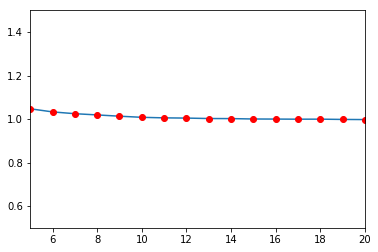

In [34]:
x_val = [k for k, _ in k_evaluations]
y_val = [error for _, error in k_evaluations]
plt.plot(x_val, y_val)
plt.plot(x_val, y_val,'or')
plt.xlim(5, 20)
plt.ylim(0.5, 1.5)
plt.show()